<a href="https://colab.research.google.com/github/gajulaakanksha/Finance_PL_BOT/blob/main/Finance_pl.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
pip install streamlit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.1/9.1 MB 50.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 63.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 4.1 MB/s eta 0:00:00


In [4]:
pip install langchain_groq

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.6/109.6 kB 4.1 MB/s eta 0:00:00


In [6]:
pip install langchain_community

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 29.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.8/50.8 kB 4.2 MB/s eta 0:00:00


In [47]:
pip install PyPDF

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 298.0/298.0 kB 4.4 MB/s eta 0:00:00


In [8]:
pip install PyPDF2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232.6/232.6 kB 4.3 MB/s eta 0:00:00


In [64]:
pip install langchain_huggingface

In [86]:
!pip install faiss-cpu


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.5/27.5 MB 59.9 MB/s eta 0:00:00


# Creating a file as main.py
This file to develop a Financial ChatBot which can answer the questions based on the uploaded Profit & Loss (P&L) table extracted from PDF documents.
By using Streamlit, Langchain, Groq, Hugging Face Embedding.

In [106]:
%%writefile main.py
## Importing Necessary Librabies
import streamlit as st                                                            # Streamlit to build a user-friendly interface
import os                                                                         # Used for accessing environment variables and file system operations
from langchain_groq import ChatGroq                                               # Used to initialize and interact with the Groq LLM
from langchain.text_splitter import RecursiveCharacterTextSplitter                # Splits large text into smaller chunks for embedding and retrieval
from langchain.chains.combine_documents import create_stuff_documents_chain       # Used to process and summarize document chunks during retrieval
from langchain_core.prompts import ChatPromptTemplate                             # Imports a utility for defining custom prompts for LLMs
from langchain.chains import create_retrieval_chain                               # Combines the vector retriever with the LLM to answer questions
from langchain_community.vectorstores import FAISS                                # Used to store document embeddings and perform vector-based retrieval
from langchain_community.document_loaders import PyPDFLoader                      # Imports a loader to extract text from PDF files.
from langchain.embeddings import HuggingFaceEmbeddings                            # Converts text into numerical vector representations for similarity search
import PyPDF2                                                                     # Provides additional utilities for PDF processing
import pandas as pd                                                               # data handling
from dotenv import load_dotenv                                                    # loads environment variables from a .env file
import tempfile                                                                   # Provides utilities for temporary file handling
import time                                                                       # measuring time

# Load environment variables
load_dotenv()
os.environ['GROQ_API_KEY'] = os.getenv("GROQ_API_KEY")                            # Ensures secure API access for interacting with the Groq LLM
groq_api_key = os.getenv("GROQ_API_KEY")

import os

# Initialize Groq LLM
llm = ChatGroq(groq_api_key=groq_api_key, model_name="Llama3-8b-8192")

# Define the prompt
prompt = ChatPromptTemplate.from_template(
    """
    Answer the questions based on the provided context only.
    Please provide the most accurate response based on the question.
    <context>
    {context}
    </context>
    Question: {input}
    """
)

# Vector embedding function
def create_vector_embedding(uploaded_file):
    if "vectors" not in st.session_state:                                                                                   # Checks if embeddings are already created in the Streamlit session
        with tempfile.TemporaryDirectory() as temp_dir:
            temp_file_path = os.path.join(temp_dir, uploaded_file.name)
            with open(temp_file_path, "wb") as temp_file:
                temp_file.write(uploaded_file.read())

            # Load PDF and create embeddings
            st.session_state.embeddings = HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2")         #  Converts the document into embeddings for similarity search
            loader = PyPDFLoader(temp_file_path)
            docs = loader.load()
            st.session_state.text_splitter = RecursiveCharacterTextSplitter(chunk_size=300, chunk_overlap=50)                # Splits the document into chunks of 300 characters with 50-character overlaps.
            st.session_state.final_documents = st.session_state.text_splitter.split_documents(docs)
            st.session_state.vectors = FAISS.from_documents(st.session_state.final_documents, st.session_state.embeddings)   # Stores the embeddings in a FAISS vector database.
            st.success("Vector database created successfully!")

# Streamlit UI
st.title("Financial QA Bot")                                                           # Displays a title as Financial QA Bot

# Upload PDF
uploaded_file = st.file_uploader("Upload P&L PDF", type=["pdf"])                       # Displays a file upload widget for users to upload financial documents

if uploaded_file:
    st.write("PDF file uploaded successfully!")
    if st.button("Create Document Embeddings"):                                        # Processes the uploaded PDF and creates embeddings when the user clicks a button
        create_vector_embedding(uploaded_file)

# Input for financial query
user_prompt = st.text_input("Ask a question about the financial data:")                # Provides a text input field for users to enter financial queries

if user_prompt and "vectors" in st.session_state:
    document_chain = create_stuff_documents_chain(llm, prompt)                         # Retrieves relevant text and generates a response
    retriever = st.session_state.vectors.as_retriever()
    retrieval_chain = create_retrieval_chain(retriever, document_chain)

    start_time = time.process_time()
    response = retrieval_chain.invoke({'input': user_prompt})                          # Measures the time taken to process the query and displays the response time
    st.write(f"Response time: {time.process_time() - start_time:.2f} seconds")

    # Display the answer
    st.write("**Answer:**", response['answer'])

    # Display retrieved context
    with st.expander("Document Similarity Search"):
        for i, doc in enumerate(response['context']):
            st.write(f"**Match {i+1}:**")
            st.write(doc.page_content)
            st.write('------------------------')


Overwriting main.py


# To run streamlit code in Google Colab Using localtunnel
localtunnel provides a public URL through which the app can be accessed.


In [78]:
## Install Streamlit
! pip install streamlit -q

In [79]:
## Retrieves external IP address using the wget command.
!wget -q -O - ipv4.icanhazip.com

35.194.145.32


In [108]:
## Runs the Streamlit app in the background & expose the locally running Streamlit app to the internet
!streamlit run main.py & npx localtunnel --port 8501



⠙⠹⠸
  You can now view your Streamlit app in your browser.

  Local URL: http://localhost:8501
  Network URL: http://172.28.0.12:8501
  External URL: http://35.194.145.32:8501

⠼⠴⠦your url is: https://nice-regions-talk.loca.lt
  Stopping...
^C


# Example Interaction of the Finance QA Bot
1.   "What are the total expenses for Q2 2023?"
2.   "Show the operating margin for the past 6 months."
3.   "What is the gross profit for Q3 2024?"
4.   "How do the net income and operating expenses compare for Q1 2024?"









# 1. "What are the total expenses for Q2 2023?"



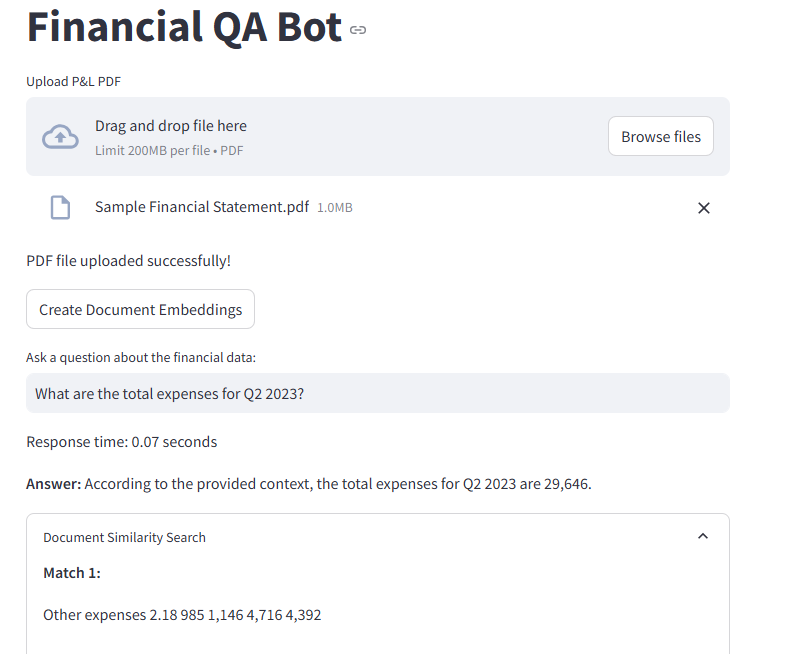

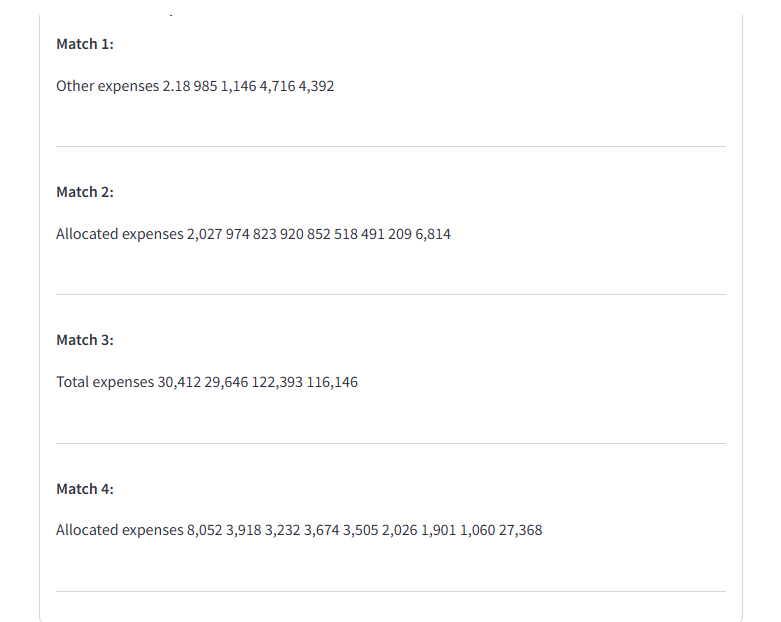

# 2.  "Show the operating margin for the past 6 months


# 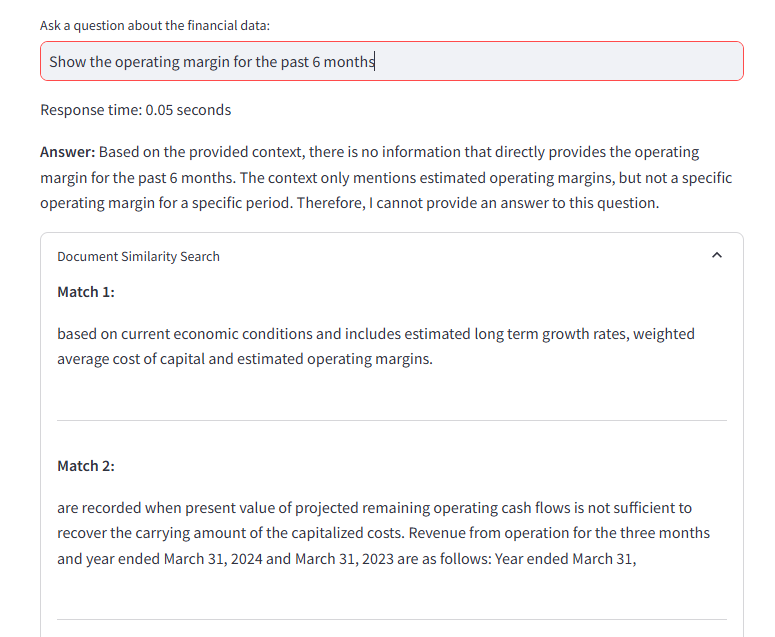



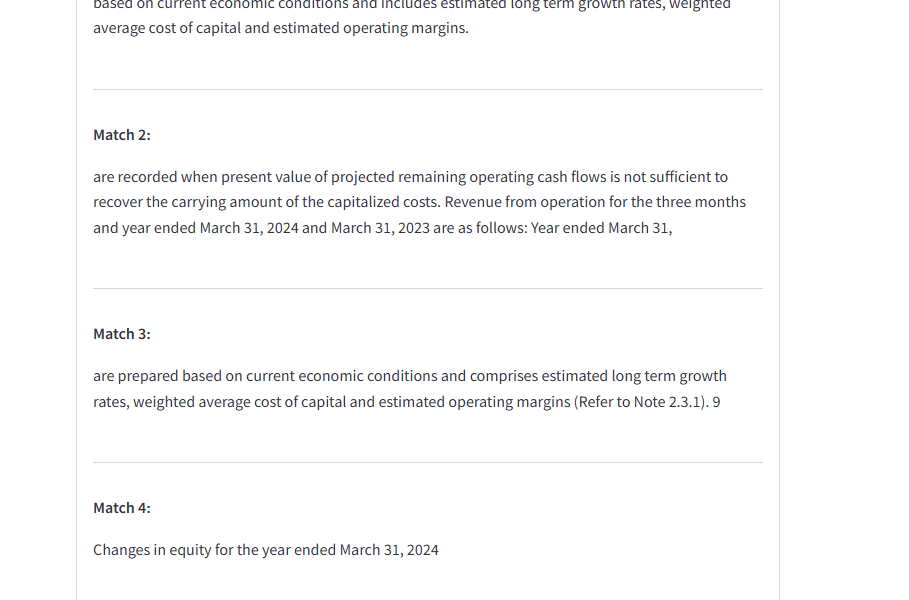

# 3. "What is the gross profit for Q3 2024?"
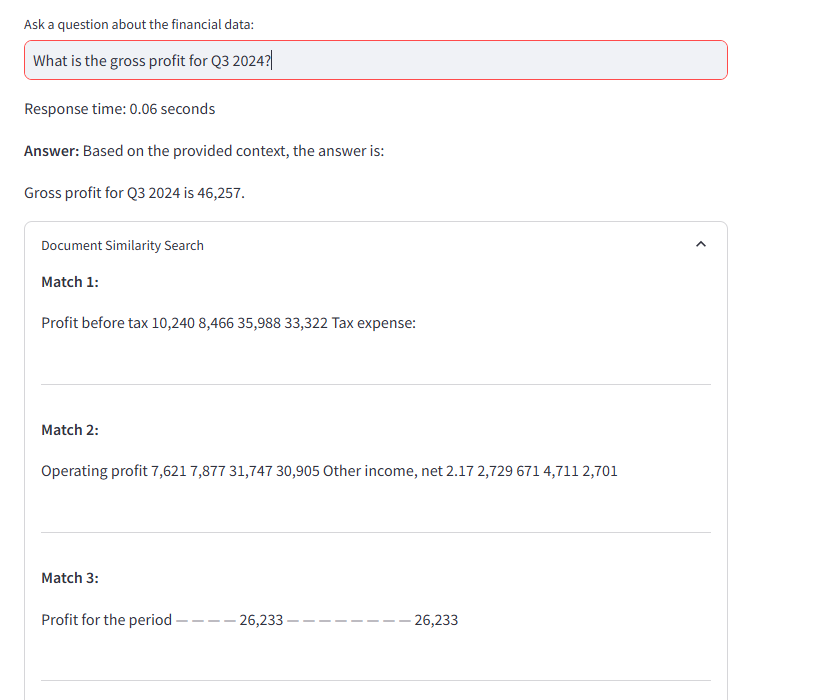

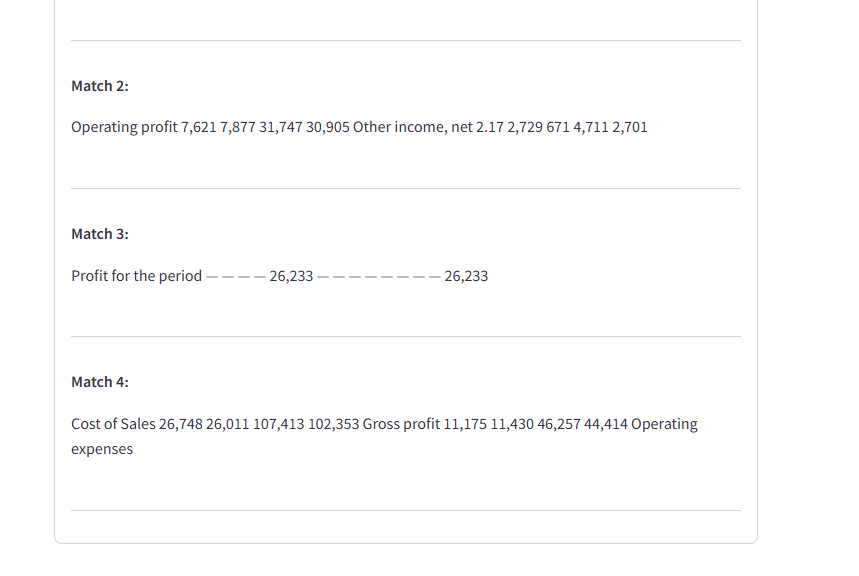

# 4. "How do the net income and operating expenses compare for Q1 2024?"


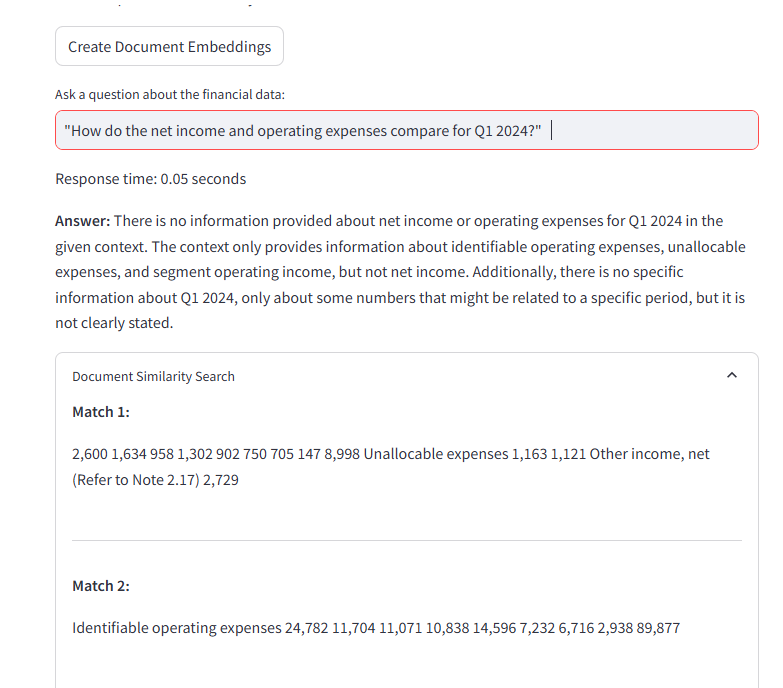

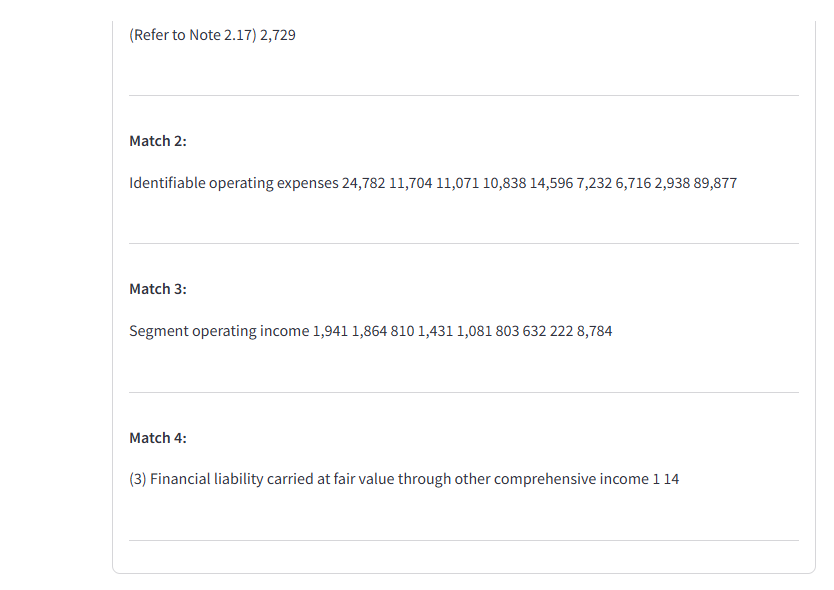